data: kaggle
https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification/data/code


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [30]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [31]:
df = pd.read_csv("/content/WELFake_Dataset.csv")
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [33]:
# xoá cột Unnamed:
df = df.drop(columns=['Unnamed: 0'])
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [34]:
# đếm nhãn:
df['label'].value_counts()

,count
label,
1,37106
0,35028


- số lượng nhãn giữa 1 và 0 cân bằng, không có sự chênh lệch nhãn

In [35]:
# kiểm tra missing data:
df.isnull().sum()

,0
title,558
text,39
label,0


In [36]:
# hiển thị dòng thiếu:
df[df.isnull().any(axis=1)]

,title,text,label
1,NaN,Did they post their votes for Hillary already?,1
43,NaN,True. Hillary needs a distraction and what bet...,1
162,NaN,All eyes on Electoral delegates. The People kn...,1
185,NaN,Cool,1
269,NaN,A leading US senator: US Supporting War in Syr...,1
...,...,...,...
71484,NaN,Another Arab supremacist masturbation fantasy....,1
71521,NaN,I'm sure they drastically changed accounting m...,1
71540,NaN,It's easy to imagine Obama or Kerry pissing hi...,1
71570,NaN,Ever since the powers to be assassinated JFK A...,1


- thay nan bằng chuỗi dữ liệu trống vì: Chuỗi rỗng '' được hiểu là “không có nội dung”, nhưng vẫn là dữ liệu hợp lệ. Nó giúp các bước tiền xử lý (như tokenization, vector hóa TF-IDF, embedding, BERT tokenizer, v.v.) không bị lỗi.
- => Chuỗi rỗng đôi khi là tín hiệu chứ không phải lỗi dữ liệu.

# Tiền xử lý dữ liệu

In [37]:
# chuyển giá trị nan thành chuỗi dữ liệu trống " "
df = df.fillna('')
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [38]:
# gộp văn bản:  Tạo cột content = title + text
df['content'] = df['title'] + ' ' + df['text']


In [39]:
# đếm số chữ cái trong văn bản:
df["body_len"] = df["content"].apply(lambda x: len(x) - x.count(" "))
df.head()


,title,text,label,content,body_len
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,4222
1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?,39
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,299
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",6811
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,1668


In [40]:
# =============================
# Tải tài nguyên NLTK
# =============================
for pkg in ['stopwords', 'wordnet', 'omw-1.4']:
    try:
        nltk.data.find(f'corpora/{pkg}')
    except LookupError:
        nltk.download(pkg)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [41]:
# =============================
# Hàm làm sạch văn bản
# =============================
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|@\w+|#\w+', ' ', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)


In [42]:
# =============================
# Áp dụng làm sạch
# =============================
df['clean_text'] = df['content'].apply(clean_text)

# Loại bỏ dòng trống
df = df[df['clean_text'].str.strip() != ''].copy()
df

,title,text,label,content,body_len,clean_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,4222,law enforcement high alert following threat co...
1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?,39,post vote hillary already
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,299,unbelievable obama attorney general say charlo...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",6811,bobby jindal raised hindu us story christian c...
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,1668,satan 2 russia unvelis image terrifying new su...
...,...,...,...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,Russians steal research on Trump in hack of U....,4098,russian steal research trump hack u democratic...
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,WATCH: Giuliani Demands That Democrats Apolog...,3092,watch giuliani demand democrat apologize trump...
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,Migrants Refuse To Leave Train At Refugee Camp...,2447,migrant refuse leave train refugee camp hungar...
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0,Trump tussle gives unpopular Mexican leader mu...,2868,trump tussle give unpopular mexican leader muc...


# chia tập train, test trước khi biểu diễn văn bản

chia 8 phần train, 2 phần test

In [43]:
# ============================================
# CHIA DỮ LIỆU TRAIN/TEST
# ============================================

from sklearn.model_selection import train_test_split

# Biến độc lập (X) là văn bản sạch, biến mục tiêu (y) là nhãn tin giả/thật
X = df['clean_text']
y = df['label']

# Chia dữ liệu: 80% train, 20% test (stratify để giữ tỷ lệ nhãn cân bằng)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(" Dữ liệu đã được chia:")
print(f"- Train size: {len(X_train)} mẫu")
print(f"- Test size : {len(X_test)} mẫu")

# Kiểm tra tỷ lệ nhãn giữa train/test
print("\n Tỷ lệ nhãn trong train:")
print(y_train.value_counts(normalize=True))
print("\n Tỷ lệ nhãn trong test:")
print(y_test.value_counts(normalize=True))


 Dữ liệu đã được chia:
- Train size: 57689 mẫu
- Test size : 14423 mẫu

 Tỷ lệ nhãn trong train:
label
1    0.514257
0    0.485743
Name: proportion, dtype: float64

 Tỷ lệ nhãn trong test:
label
1    0.514248
0    0.485752
Name: proportion, dtype: float64


# Biểu diễn văn bản: TF-IDF

In [44]:
# ============================================
# BIỂU DIỄN VĂN BẢN - TF-IDF VECTORIZER
# ============================================

from sklearn.feature_extraction.text import TfidfVectorizer

# Khởi tạo TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,        # chỉ lấy 5000 từ quan trọng nhất
    ngram_range=(1, 2),       # dùng cả unigram và bigram
    min_df=5,                 # chỉ giữ từ xuất hiện ít nhất 5 lần
    max_df=0.8,               # loại từ xuất hiện quá phổ biến (>80%)
    sublinear_tf=True,        # dùng log-scaling để giảm ảnh hưởng của tần suất cao
)

# Học TF-IDF trên tập train, sau đó biến đổi cả train và test
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

print(" TF-IDF biểu diễn xong:")
print(f"- Kích thước tập train: {X_train_tfidf.shape}")
print(f"- Kích thước tập test : {X_test_tfidf.shape}")

# Xem thử 10 đặc trưng đầu tiên
print("\n Một vài đặc trưng TF-IDF đầu tiên:")
print(tfidf.get_feature_names_out()[:10])


 TF-IDF biểu diễn xong:
- Kích thước tập train: (57689, 5000)
- Kích thước tập test : (14423, 5000)

 Một vài đặc trưng TF-IDF đầu tiên:
['00' '000' '000 people' '10' '10 000' '10 percent' '10 year' '100'
 '100 000' '11']


# Model truyền thống

# Naive Bayes

In [45]:
# ============================================
#  XÂY DỰNG MÔ HÌNH NAIVE BAYES
# ============================================

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [46]:
#  Khởi tạo mô hình Naive Bayes (phù hợp cho dữ liệu TF-IDF)
nb_model = MultinomialNB(alpha=0.1)  # alpha = 0.1 để làm mượt (Laplace smoothing)

#  Huấn luyện mô hình trên tập train
nb_model.fit(X_train_tfidf, y_train)


MultinomialNB(alpha=0.1)

In [47]:
#  Dự đoán trên tập test
y_pred = nb_model.predict(X_test_tfidf)

#  Đánh giá hiệu năng mô hình
acc = accuracy_score(y_test, y_pred)
print(f" Độ chính xác (Accuracy): {acc:.4f}")

print("\n Báo cáo phân loại (Classification Report):")
print(classification_report(y_test, y_pred, digits=4))

# Ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)


 Độ chính xác (Accuracy): 0.8601

 Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0     0.8776    0.8273    0.8517      7006
           1     0.8452    0.8911    0.8676      7417

    accuracy                         0.8601     14423
   macro avg     0.8614    0.8592    0.8596     14423
weighted avg     0.8610    0.8601    0.8599     14423



độ chính xác: 86.01


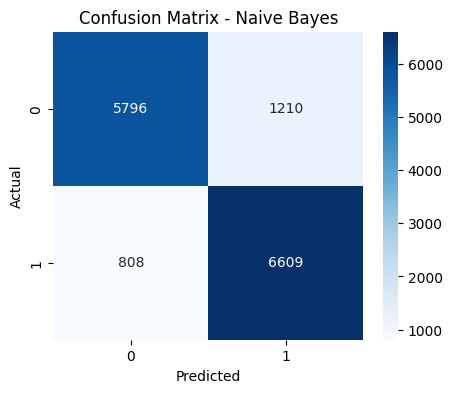

In [48]:

# Trực quan hóa kết quả
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()


# LogisticRegression

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [50]:
# Khởi tạo mô hình Logistic Regression
log_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)


In [51]:
# X_train_tfidf, y_train từ bước TF-IDF
log_model.fit(X_train_tfidf, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [52]:
y_pred = log_model.predict(X_test_tfidf)
y_prob = log_model.predict_proba(X_test_tfidf)[:,1]


In [53]:
print("Độ chính xác (Accuracy):", accuracy_score(y_test, y_pred))
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred, target_names=['Tin thật', 'Tin giả']))

print("\nMa trận nhầm lẫn (Confusion Matrix):")
print(confusion_matrix(y_test, y_pred))


Độ chính xác (Accuracy): 0.9604104555224294

Báo cáo phân loại:
              precision    recall  f1-score   support

    Tin thật       0.96      0.96      0.96      7006
     Tin giả       0.96      0.96      0.96      7417

    accuracy                           0.96     14423
   macro avg       0.96      0.96      0.96     14423
weighted avg       0.96      0.96      0.96     14423


Ma trận nhầm lẫn (Confusion Matrix):
[[6696  310]
 [ 261 7156]]


độ chính xác: 96.041045


# Model học sâu

# mô hình Dense

In [54]:
# xây dựng mô hình:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(X_train_tfidf.shape[1],)),  # số chiều bằng số đặc trưng TF-IDF
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  # nhị phân: giả hay thật
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313,281 (5.01 MB)

 Trainable params: 1,313,281 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

| Layer       | Loại lớp            | Đầu ra (Output Shape) | Số tham số (Param #) | Ý nghĩa                                                                                          |
| ----------- | ------------------- | --------------------- | -------------------- | ------------------------------------------------------------------------------------------------ |
| `Dense`     | 256 neurons, `ReLU` | `(None, 256)`         | **1,280,256**        | Lớp ẩn đầu tiên, học các đặc trưng từ vector TF-IDF (10k chiều nếu bạn dùng max_features=10000). |
| `Dropout`   | 0.3                 | `(None, 256)`         | 0                    | Giảm overfitting bằng cách ngẫu nhiên “tắt” 30% neurons khi huấn luyện.                          |
| `Dense_1`   | 128 neurons, `ReLU` | `(None, 128)`         | 32,896               | Lớp ẩn thứ hai, học các biểu diễn cấp cao hơn.                                                   |
| `Dropout_1` | 0.2                 | `(None, 128)`         | 0                    | Tiếp tục regularization để tránh overfit.                                                        |
| `Dense_2`   | 1 neuron, `sigmoid` | `(None, 1)`           | 129                  | Lớp đầu ra, dự đoán xác suất “tin giả” (1) hoặc “tin thật” (0).                                  |


- Tổng kết thông số

Tổng tham số: 1,313,281 (≈ 5.01 MB)

Tất cả đều trainable:

Không có tham số cố định (non-trainable): 0

Điều này có nghĩa là toàn bộ mô hình đều được tối ưu hóa trong quá trình huấn luyện.

Nhận xét chuyên môn

1. Điểm mạnh:

Mô hình được thiết kế chuẩn cho bài toán phân loại văn bản với TF-IDF.

Dễ huấn luyện, nhanh, phù hợp chạy trên CPU hoặc GPU Colab.

Có Dropout giúp mô hình tránh học thuộc (overfitting).

Kích thước mô hình vừa phải (~5MB), có thể deploy dễ dàng.

2. Lưu ý cải thiện:

Có thể thêm BatchNormalization giữa các lớp Dense để ổn định huấn luyện.

Nếu tập dữ liệu lớn, có thể tăng max_features của TF-IDF lên 20.000 hoặc thêm một lớp Dense nhỏ hơn (32 neurons) ở cuối.

Số epoch nên bắt đầu từ 5–10, dùng EarlyStopping để dừng sớm nếu overfit.

3. Kết luận

Mô hình:

-  Được xây dựng đúng cấu trúc, có khả năng học biểu diễn mạnh mẽ từ TF-IDF.
- Sẵn sàng huấn luyện (model.fit()) để dự đoán tin thật/giả.
- Là lựa chọn hiệu quả, dễ triển khai hơn LSTM trong thực nghiệm phát hiện tin giả.

In [55]:
# huấn luyện mô hình:
history = model.fit(
    X_train_tfidf.toarray(),  # chuyển từ sparse → dense
    y_train,
    validation_split=0.2,
    epochs=16,
    batch_size=128,
    verbose=1
)


Epoch 1/16
361/361 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8925 - loss: 0.2932 - val_accuracy: 0.9601 - val_loss: 0.1096
Epoch 2/16
361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9746 - loss: 0.0720 - val_accuracy: 0.9638 - val_loss: 0.1015
Epoch 3/16
361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9883 - loss: 0.0397 - val_accuracy: 0.9652 - val_loss: 0.1059
Epoch 4/16
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9949 - loss: 0.0172 - val_accuracy: 0.9646 - val_loss: 0.1226
Epoch 5/16
361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9983 - loss: 0.0075 - val_accuracy: 0.9670 - val_loss: 0.1327
Epoch 6/16
361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9991 - loss: 0.0048 - val_accuracy: 0.9658 - val_loss: 0.1499
Epoch 7/16
361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9991 - loss: 0.0045 - val_accuracy: 0.9670 - val_loss: 0.1647
Epoch 8/16
361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0

451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      7006
           1       0.97      0.97      0.97      7417

    accuracy                           0.97     14423
   macro avg       0.97      0.97      0.97     14423
weighted avg       0.97      0.97      0.97     14423


 Confusion Matrix:
[[6750  256]
 [ 223 7194]]


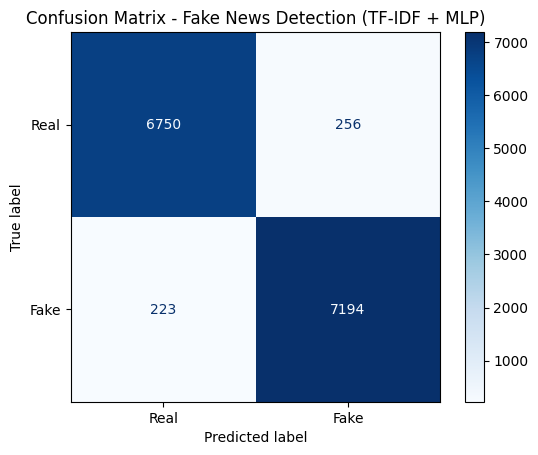

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Dự đoán nhãn (0 hoặc 1)
y_pred = (model.predict(X_test_tfidf.toarray()) > 0.5).astype(int)

# Báo cáo phân loại
print(" Classification Report:")
print(classification_report(y_test, y_pred))

# Ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
print("\n Confusion Matrix:")
print(cm)

# Hiển thị trực quan
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Fake News Detection (TF-IDF + MLP)")
plt.show()
